In [374]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm.auto import tqdm

from src.IterativeFitting import IterativeFitting as IF
from src.CorrFuncs import covariance_matrix, trend_est

In [363]:
# Setting seed
golden_seed = 6
seed = 8
np.random.seed(seed)

# Initializing simulation slope and intercept parameters
beta0 = -0.1
beta1 = 0.02
beta_age = 0.05
beta_income = -0.05
beta_sex = 1.0

# Number of samples
n = 40000

# Constructing covariate vectors for additional covariates to adjust
age_vector = np.random.uniform(low=0,high=1,size=n)
income_vector = np.random.uniform(low=0,high=1,size=n)
# sex_vector = np.random.binomial(n=1,p=0.6,size=n)

# Assigning exposure levels and getting relevant x's
exposure_levels = np.array([0.,1.,2.,3.])
xs = np.random.choice(exposure_levels,size = n)
sex_vector = np.random.binomial(n = 1,p = 0.1 + xs/4,size =n )


# Function to generate probabilities of being a case v non-case
other_covs = beta0 + (beta_age*age_vector) + (income_vector*beta_income) + (sex_vector*beta_sex) 
p = lambda x: (np.exp(beta1*x + other_covs))/(1 + np.exp(beta1*x + other_covs))

# Actually calculating probabilities on exposures as defined
px = p(xs)

# Actually assigning to case or not
outcomes = np.array([np.random.binomial(n=1,p=p,size=1)[0] for p in px])

# Constructing and sorting dataframe of outcomes and exposure
df = np.stack([outcomes,xs],axis=1)
# df = df[np.argsort(df[:, 1])]

# Getting xs corresponding to each exposure interval and corresponding case information
categories = [df[np.where(df[:,1] == i)[0]] for i in exposure_levels]
N = np.array([df.shape[0] for df in categories])
cases = np.array([np.sum(df[:,0]) for df in categories])
non_cases = N - cases
a_0, A = cases[0], cases[1:]
b_0, B = non_cases[0], non_cases[1:]
M = np.sum(cases)

# Getting crude estimates to compare
crude = lambda x,y: (x/y) / (a_0/b_0)
crudeors = crude(A,B)

# Constructing dummy variables with respect to exposure level
x = exposure_levels[1:]

to_adjust_df = pd.DataFrame({
    'age':age_vector,
    'income':income_vector,
    'sex':sex_vector,
    'exposure':xs.astype(int)
})
to_adjust_df['intercept']=1

to_adjust_df = pd.concat([to_adjust_df,pd.get_dummies(to_adjust_df['exposure'],prefix='exposure').astype(int).iloc[:,1:]],axis=1).drop('exposure',axis=1)

results = sm.Logit(endog=df[:,0], exog=to_adjust_df).fit()
true_C = results.cov_params().to_numpy()[4:,4:]
true_C_inv = np.linalg.inv(true_C)

# Get log-ORs and corresponding variances
L = results.params.to_numpy()[4:]
v = (results.bse.to_numpy()[4:])**2

Optimization terminated successfully.
         Current function value: 0.645992
         Iterations 5


In [364]:
np.exp(L)

array([0.99795593, 1.0243074 , 1.04804608])

In [365]:
crudeors

array([1.2551063 , 1.64324092, 2.17078667])

In [366]:
# Running GL
it_fit_ex = IF(L,A,N,M)
Ap, Bp, a0p, b0p = it_fit_ex.convexProgram()

C = covariance_matrix(Ap,Bp,a0p,b0p,v)
inv_C = np.linalg.inv(C)

In [367]:
# Recovering slope estimate for corrected correlation
vb_star = 1 / (x.T@inv_C@x)
b_star = vb_star*(x.T@inv_C@L)
b_star

0.016390360054777876

In [368]:
# Recovering standard slope estimate
vb = 1/(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),x)))
b = vb*(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),L)))
b

0.01281627465337195

In [369]:
rootWols = np.diag(1/np.sqrt(v))
X_intercept_ols = np.vstack([np.ones(len(x)),x]).T
intercept_ols_slope = np.linalg.lstsq(rootWols@X_intercept_ols,rootWols@L,rcond = 1e-15)[0][1]
intercept_ols_slope

0.024585115874140674

In [370]:
# Getting Oracle estimates
vb_oracle = 1/(np.dot(x,np.dot(true_C_inv,x)))
b_oracle = vb_oracle*(np.dot(x,np.dot(true_C_inv,L)))
b_oracle

0.01633161515485301

In [371]:
# Getting estimates from covariance matrix generated from raw counts
C_raw = covariance_matrix(A,B,a_0,b_0,v)
inv_C_raw = np.linalg.inv(C_raw)

vb_r = 1/(x.T@inv_C_raw@x)
b_r = vb_r*(x.T@inv_C_raw@L)
b_r

0.016216320901233153

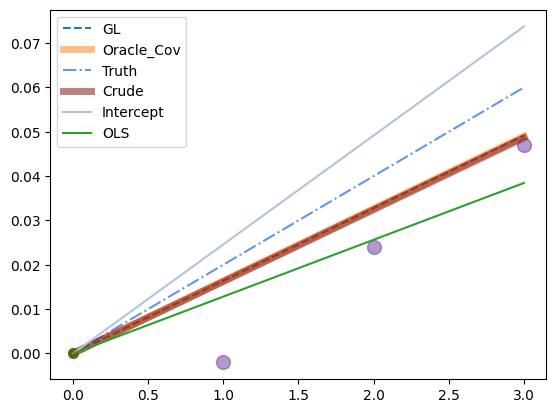

In [372]:
x_valsp = np.hstack([0,x])
plt.scatter(x,L,alpha=0.5,c="rebeccapurple",s=100)
plt.scatter(0,0,s=50,c="forestgreen")
plt.plot(x_valsp,b_star*x_valsp,label = 'GL',linestyle = 'dashed')
plt.plot(x_valsp,b_oracle*x_valsp,label = 'Oracle_Cov', alpha = 0.5,lw = 5)
plt.plot(x_valsp,beta1*x_valsp,label = 'Truth',c="cornflowerblue",linestyle="dashdot")
plt.plot(x_valsp,b_r*x_valsp,label="Crude",c="maroon",lw = 5,alpha = 0.5)
plt.plot(x_valsp,intercept_ols_slope*x_valsp,label="Intercept",c="lightsteelblue")
plt.plot(x_valsp,b*x_valsp,label = "OLS")
plt.legend()

In [399]:
from scipy.special import logit,expit

In [454]:
GL_pe_list = []
GL_v_list = []
oracle_pe_list = []
oracle_v_list = []
OLS_pe_list = []
OLS_v_list = []
crude_pe_list = []
crude_v_list = []

# Setting seed
golden_seed = 6
seed = 8
np.random.seed(seed)

# Initializing simulation slope and intercept parameters
beta0 = -0.1
beta1 = 0.02
beta_age = 0.05
beta_income = -0.05
beta_sex = 1.0

# Number of samples
n = 1000

# Simulation number
sim_no = 10000

for i in tqdm(range(sim_no)):
    # Constructing covariate vectors for additional covariates to adjust
    age_vector = np.random.uniform(low=0,high=1,size=n)
    income_vector = np.random.uniform(low=0,high=1,size=n)
    # sex_vector = np.random.binomial(n=1,p=0.6,size=n)

    # Assigning exposure levels and getting relevant x's
    exposure_levels = np.array([0.,1.,2.,3.])
    xs = np.random.choice(exposure_levels,size = n,p = np.array([0.04,0.32,0.32,0.32]))
    sex_vector = np.random.binomial(n = 1,p = 0.1 + xs/4,size =n )


    # Function to generate probabilities of being a case v non-case
    other_covs = beta0 + (beta_age*age_vector) + (income_vector*beta_income) + (sex_vector*beta_sex) 
    #p = lambda x: (np.exp(beta1*x + other_covs))/(1 + np.exp(beta1*x + other_covs))
    px = (expit(beta1*xs+other_covs))

    # Actually calculating probabilities on exposures as defined
    #px = p(xs)

    # Actually assigning to case or not
    outcomes = np.array([np.random.binomial(n=1,p=p,size=1)[0] for p in px])

    # Constructing and sorting dataframe of outcomes and exposure
    df = np.stack([outcomes,xs],axis=1)
    # df = df[np.argsort(df[:, 1])]

    # Getting xs corresponding to each exposure interval and corresponding case information
    categories = [df[np.where(df[:,1] == i)[0]] for i in exposure_levels]
    N = np.array([df.shape[0] for df in categories])
    cases = np.array([np.sum(df[:,0]) for df in categories])
    non_cases = N - cases
    a_0, A = cases[0], cases[1:]
    b_0, B = non_cases[0], non_cases[1:]
    M = np.sum(cases)

    # Getting crude estimates to compare
    crude = lambda x,y: (x/y) / (a_0/b_0)
    crudeors = crude(A,B)

    # Constructing dummy variables with respect to exposure level
    x = exposure_levels[1:]

    to_adjust_df = pd.DataFrame({
        'age':age_vector,
        'income':income_vector,
        'sex':sex_vector,
        'exposure':xs.astype(int)
    })
    to_adjust_df['intercept']=1

    to_adjust_df = pd.concat([to_adjust_df,pd.get_dummies(to_adjust_df['exposure'],prefix='exposure').astype(int).iloc[:,1:]],axis=1).drop('exposure',axis=1)

    results = sm.Logit(endog=outcomes, exog=to_adjust_df).fit(disp=0)
    num_exposures = len(exposure_levels)-1
    true_C = results.cov_params().to_numpy()[-num_exposures:,-num_exposures:]
    true_C_inv = np.linalg.inv(true_C)

    # Get log-ORs and corresponding variances
    L = results.params.to_numpy()[-num_exposures:]
    v = (results.bse.to_numpy()[-num_exposures:])**2

    # Running GL
    it_fit_ex = IF(L,A,N,M)
    Ap, Bp, a0p, b0p = it_fit_ex.convexProgram()

    C = covariance_matrix(Ap,Bp,a0p,b0p,v)
    inv_C = np.linalg.inv(C)

    # Recovering slope estimate for corrected correlation
    vb_star = 1 / (x.T@inv_C@x)
    b_star = vb_star*(x.T@inv_C@L)
    GL_pe_list.append(b_star)
    GL_v_list.append(vb_star)

    # Recovering OLS estimates
    vb = 1/(x.T@(np.diag(1/v))@x)
    b = vb*(x.T@np.diag(1/v)@L)

    # vb = 1/(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),x)))
    # b = vb*(np.dot(x,np.dot(np.linalg.inv(np.diag(v)),L)))
    OLS_pe_list.append(b)
    OLS_v_list.append(vb)

    # Getting Oracle estimates
    vb_oracle = 1/(x.T@true_C_inv@x)

    #vb_oracle = 1/(np.dot(x,np.dot(true_C_inv,x)))
    b_oracle = vb_oracle*(x.T@true_C_inv@L)
    # b_oracle = vb_oracle*(np.dot(x,np.dot(true_C_inv,L)))
    oracle_pe_list.append(b_oracle)
    oracle_v_list.append(vb_oracle)

    # Getting estimates from covariance matrix generated from raw counts
    C_raw = covariance_matrix(A,B,a_0,b_0,v)
    inv_C_raw = np.linalg.inv(C_raw)

    vb_r = 1/(x.T@inv_C_raw@x)
    b_r = vb_r*(x.T@inv_C_raw@L)
    crude_pe_list.append(b_r)
    crude_v_list.append(vb_r)

100%|██████████| 10000/10000 [01:46<00:00, 94.21it/s]


In [455]:
variance_estimates = pd.DataFrame({"OLS": OLS_v_list,
'GL':GL_v_list,
"Oracle":oracle_v_list,
"Crude":crude_v_list}
)
variance_estimates


,OLS,GL,Oracle,Crude
0,0.010305,0.005679,0.007628,0.006554
1,0.008268,0.006382,0.007055,0.006298
2,0.008567,0.006027,0.007294,0.006462
3,0.007378,0.005819,0.007225,0.006671
4,0.007610,0.006203,0.007066,0.006479
...,...,...,...,...
9995,0.007906,0.005801,0.007008,0.006322
9996,0.010099,0.006003,0.007347,0.006488
9997,0.007688,0.005823,0.006497,0.006072
9998,0.007993,0.005788,0.007178,0.006523


In [456]:
point_estimates = pd.DataFrame(
    {
        'GL':GL_pe_list,
        "Oracle":oracle_pe_list,
        "OLS":OLS_pe_list,
        "Crude":crude_pe_list,
    }
)

#point_estimates['truth']=beta1

In [457]:
std_estimate = point_estimates.std(axis=0)
std_estimate['OLS']/std_estimate['GL']

1.7666736111294707

In [459]:
std_estimate

GL        0.085481
Oracle    0.084864
OLS       0.151016
Crude     0.085286
dtype: float64

In [461]:
((point_estimates - beta1)/np.sqrt(variance_estimates)).var()

Crude     1.131738
GL        1.196753
OLS       2.330115
Oracle    0.991919
dtype: float64

In [438]:
point_estimates.mean(axis=0) + 2 * point_estimates.sem(axis=0)

GL        0.021028
Oracle    0.021457
OLS       0.020303
Crude     0.019779
truth     0.020000
dtype: float64

In [434]:
point_estimates.mean(axis=0) - 2 * point_estimates.sem(axis=0)

GL        0.008828
Oracle    0.009654
OLS       0.008620
Crude     0.007525
truth     0.020000
dtype: float64

In [419]:
point_estimates.mean(axis=0)


GL        0.020165
Oracle    0.020184
OLS       0.020200
Crude     0.020156
truth     0.020000
dtype: float64

In [ ]:
GL_pe_list = []
GL_v_list = []
oracle_pe_list = []
oracle_v_list = []
OLS_pe_list = []
OLS_v_list = []
crude_pe_list = []
crude_v_list = []


In [381]:
b_star = np.mean(GL_pe_list)
b = np.mean(OLS_pe_list)
b_oracle = np.mean(oracle_pe_list)
b_r = np.mean(crude_pe_list)

In [386]:
vb_star = np.mean(GL_v_list)
vb = np.mean(OLS_v_list)
vb_oracle = np.mean(oracle_v_list)
vb_r = np.mean(crude_v_list)

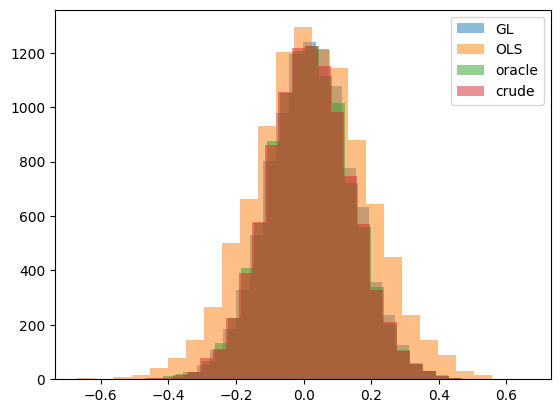

In [452]:
nbins = 25
plt.hist(GL_pe_list,bins=nbins, alpha=0.5, label="GL")
plt.hist(OLS_pe_list,bins=nbins, alpha=0.5, label="OLS")
plt.hist(oracle_pe_list,bins=nbins, alpha=0.5, label="oracle")
plt.hist(crude_pe_list,bins=nbins,alpha=0.5, label="crude")
plt.legend()

In [395]:
np.var(GL_pe_list)

0.0001243123590894898

In [398]:
np.var(OLS_pe_list)

0.00012427179561154875

In [389]:
vb_star

0.0001222559323540188

In [390]:
vb

0.0001275213856540167

In [391]:
vb_oracle

8.069133950872295e-05

In [392]:
vb_r

0.00012136997231907418